<a href="https://colab.research.google.com/github/eyaguirat10/Restaurant-segmentation/blob/main/Segmentation_res.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram

In [ ]:
restaurants = pd.read_csv("/content/restaurants.csv", delimiter=';')

In [ ]:
# Encodage simple des variables catégorielles
restaurants['Alcohol_Service'] = restaurants['Alcohol_Service'].fillna('No')

# Supprimer les espaces autour des valeurs string
restaurants['Alcohol_Service'] = restaurants['Alcohol_Service'].str.strip()
restaurants['Smoking_Allowed'] = restaurants['Smoking_Allowed'].str.strip()

# Mapping propre
alcohol_map = {'No': 0, 'Wine & Beer': 1, 'Full Bar': 2}
smoking_map = {'No': 0, 'Smoking Section': 1, 'Bar Only': 2, 'Yes': 3}
franchise_map = {'No': 0, 'Yes': 1}

restaurants['Alcohol_Num'] = restaurants['Alcohol_Service'].map(alcohol_map)
restaurants['Smoking_Num'] = restaurants['Smoking_Allowed'].map(smoking_map)
restaurants['Franchise_Num'] = restaurants['Franchise'].map({'No': 0, 'Yes': 1})

In [ ]:
X = restaurants[['Latitude', 'Longitude', 'Price_Num', 'Alcohol_Num', 'Smoking_Num', 'Franchise_Num']]

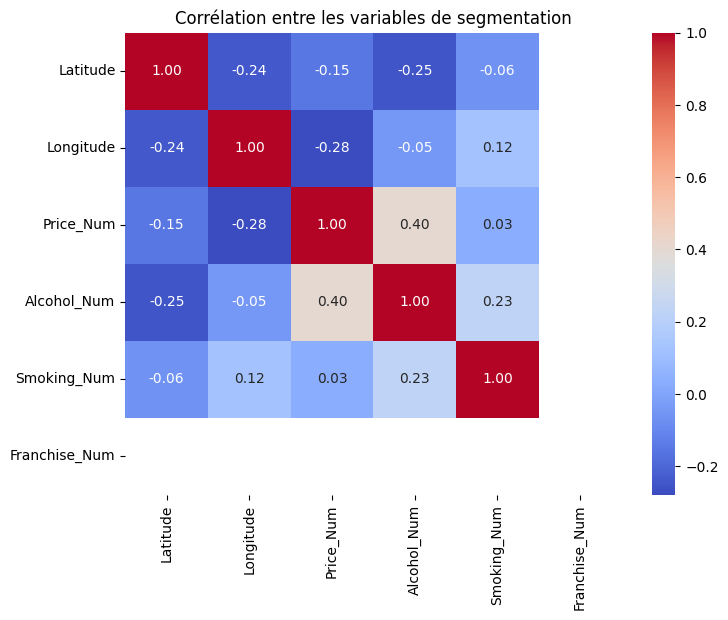

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Corrélation entre les variables de segmentation")
plt.show()


In [ ]:
print(restaurants['Alcohol_Service'].unique())
print(restaurants['Smoking_Allowed'].unique())

['No' 'Wine & Beer' 'Full Bar']
['No' 'Yes' 'Smoking Section' 'Bar Only']


In [ ]:
print(X.isnull().sum())


Latitude           0
Longitude          0
Price_Num          0
Alcohol_Num        0
Smoking_Num        0
Franchise_Num    130
dtype: int64


In [ ]:
X = X.fillna(0)  # ou X = X.fillna(X.median()) pour être plus statistique

In [ ]:
print(X.isnull().sum())


Latitude         0
Longitude        0
Price_Num        0
Alcohol_Num      0
Smoking_Num      0
Franchise_Num    0
dtype: int64


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
print(X.describe())
print(X[X.isnull().any(axis=1)])

         Latitude   Longitude   Price_Num  Alcohol_Num  Smoking_Num  \
count  130.000000  130.000000  130.000000   130.000000   130.000000   
mean    21.858863 -100.342933    1.846154     0.400000     0.423077   
std      1.496830    0.860585    0.720266     0.617572     0.834019   
min     18.859803 -101.028600    1.000000     0.000000     0.000000   
25%     22.139574 -100.987838    1.000000     0.000000     0.000000   
50%     22.149063 -100.956777    2.000000     0.000000     0.000000   
75%     22.160125  -99.220458    2.000000     1.000000     1.000000   
max     23.760268  -99.126506    3.000000     2.000000     3.000000   

       Franchise_Num  
count          130.0  
mean             0.0  
std              0.0  
min              0.0  
25%              0.0  
50%              0.0  
75%              0.0  
max              0.0  
Empty DataFrame
Columns: [Latitude, Longitude, Price_Num, Alcohol_Num, Smoking_Num, Franchise_Num]
Index: []


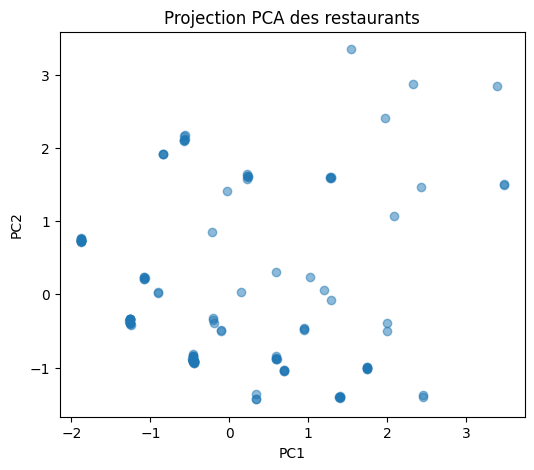

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(6,5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.title("Projection PCA des restaurants")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


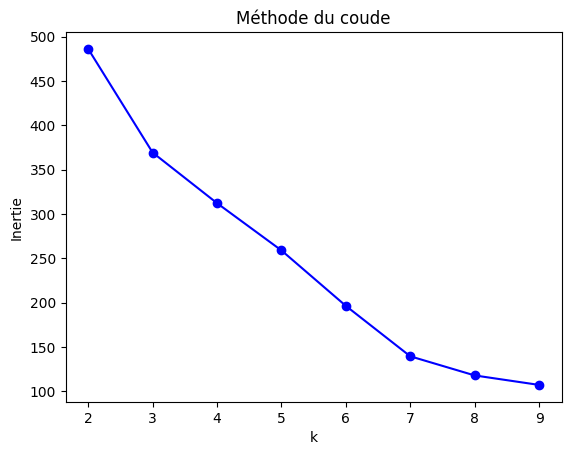

In [ ]:
inertias = []
for k in range(2, 10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.plot(range(2, 10), inertias, 'bo-')
plt.xlabel("k")
plt.ylabel("Inertie")
plt.title("Méthode du coude")
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score

for k in range(2, 10):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    print(f"Silhouette pour k={k} : {score:.3f}")

Silhouette pour k=2 : 0.388
Silhouette pour k=3 : 0.346
Silhouette pour k=4 : 0.362
Silhouette pour k=5 : 0.402
Silhouette pour k=6 : 0.474
Silhouette pour k=7 : 0.529
Silhouette pour k=8 : 0.548
Silhouette pour k=9 : 0.537


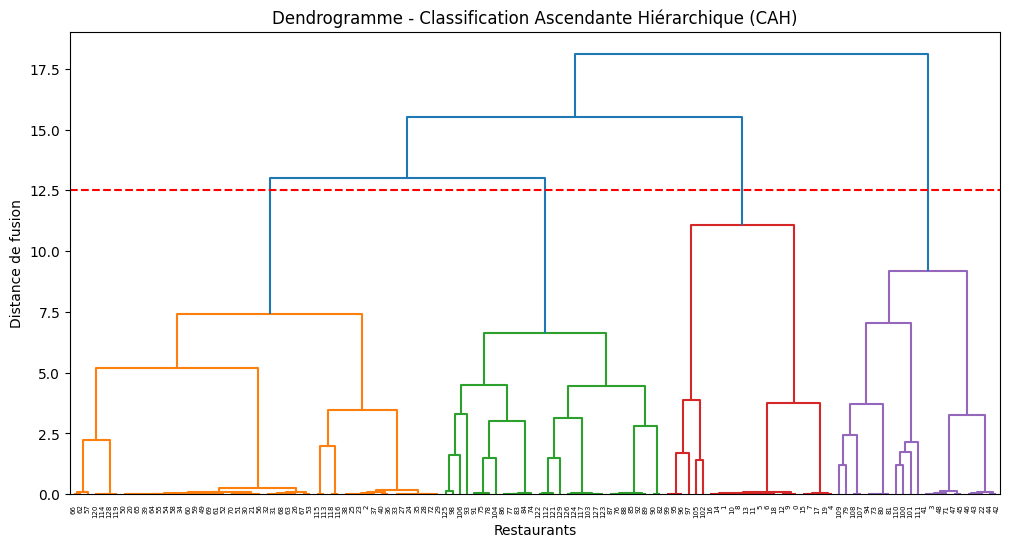

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Lien hiérarchique (ward = variance minimale intra-cluster)
linked = linkage(X_scaled, method='ward')

# Affichage du dendrogramme
plt.figure(figsize=(12, 6))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=False)

plt.title("Dendrogramme - Classification Ascendante Hiérarchique (CAH)")
plt.xlabel("Restaurants")
plt.ylabel("Distance de fusion")
plt.axhline(y=12.5, color='r', linestyle='--')
plt.show()


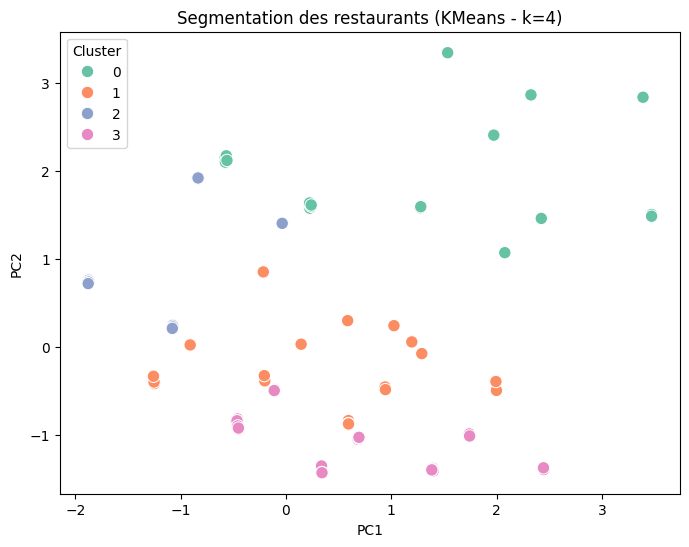


Résumé moyen par cluster :
         Price_Num  Alcohol_Num  Smoking_Num  Franchise_Num
Cluster                                                    
0             1.87         0.65         0.61            NaN
1             1.37         0.60         0.49            NaN
2             1.27         0.00         0.55            NaN
3             2.42         0.32         0.24            NaN

Effectif de chaque cluster :
Cluster
3    50
1    35
0    23
2    22
Name: count, dtype: int64


In [ ]:
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

# Clustering final avec k = 4
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
restaurants['Cluster'] = kmeans.fit_predict(X_scaled)

# Visualisation PCA avec couleurs de clusters
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=restaurants['Cluster'], palette="Set2", s=80)
plt.title("Segmentation des restaurants (KMeans - k=4)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.show()

# Analyse descriptive des clusters
cluster_summary = restaurants.groupby('Cluster')[['Price_Num', 'Alcohol_Num', 'Smoking_Num', 'Franchise_Num']].mean().round(2)
print("\nRésumé moyen par cluster :")
print(cluster_summary)

# Comptage des restaurants par cluster
print("\nEffectif de chaque cluster :")
print(restaurants['Cluster'].value_counts())


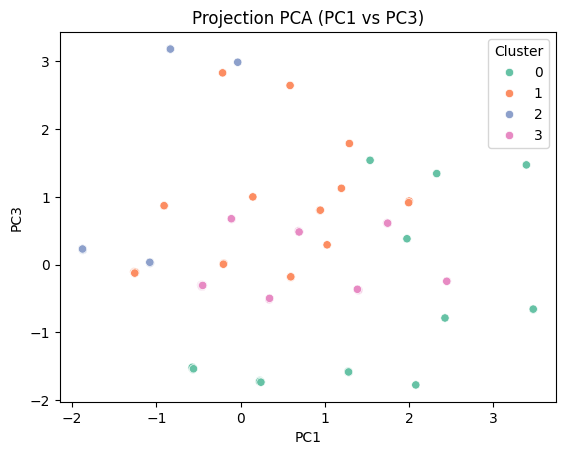

In [ ]:
pca = PCA(n_components=3)
X_pca_3d = pca.fit_transform(X_scaled)

sns.scatterplot(x=X_pca_3d[:,0], y=X_pca_3d[:,2], hue=restaurants['Cluster'], palette="Set2")
plt.title("Projection PCA (PC1 vs PC3)")
plt.xlabel("PC1")
plt.ylabel("PC3")
plt.show()

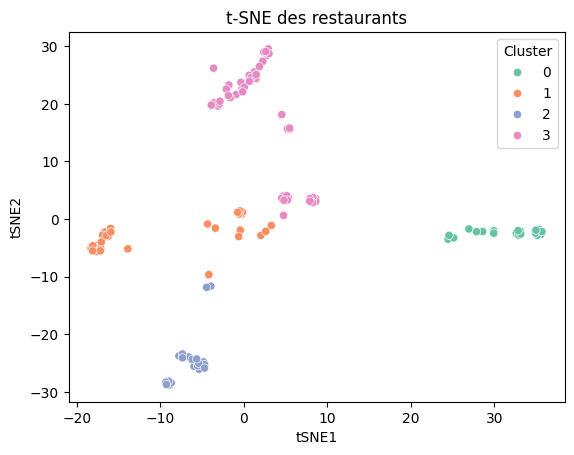

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=10, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=restaurants['Cluster'], palette="Set2")
plt.title("t-SNE des restaurants")
plt.xlabel("tSNE1")
plt.ylabel("tSNE2")
plt.show()


In [ ]:
print(restaurants.groupby("Cluster")[['Price_Num', 'Alcohol_Num', 'Smoking_Num', 'Franchise_Num']].mean().round(2))

         Price_Num  Alcohol_Num  Smoking_Num  Franchise_Num
Cluster                                                    
0             1.69         0.31         0.00            NaN
1             1.00         0.27         0.32            NaN
2             1.30         0.09         0.52            NaN
3             2.35         0.42         0.33            NaN
4             2.22         1.56         1.78            NaN


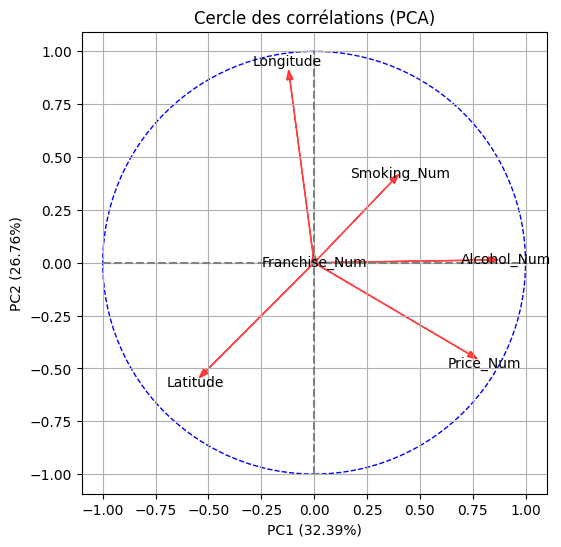

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# PCA sur tes données standardisées
pca = PCA(n_components=2)
pca.fit(X_scaled)

# Coordonnées des vecteurs (correlations variables / composantes)
components = pca.components_
circle = components.T * np.sqrt(pca.explained_variance_[:2])

plt.figure(figsize=(6,6))

# Cercle unité
plt.plot([-1,1],[0,0], color='gray', linestyle='--')
plt.plot([0,0],[-1,1], color='gray', linestyle='--')
circle1 = plt.Circle((0,0), 1, color='blue', fill=False, linestyle='--')
plt.gca().add_artist(circle1)

# Flèches + labels
for i, var in enumerate(X.columns):
    plt.arrow(0, 0, circle[i,0], circle[i,1], color='red', alpha=0.7, head_width=0.03)
    plt.text(circle[i,0]*1.1, circle[i,1]*1.1, var, ha='center', va='center')

plt.xlabel(f"PC1 ({round(pca.explained_variance_ratio_[0]*100, 2)}%)")
plt.ylabel(f"PC2 ({round(pca.explained_variance_ratio_[1]*100, 2)}%)")
plt.title("Cercle des corrélations (PCA)")
plt.axis('equal')
plt.grid(True)
plt.show()


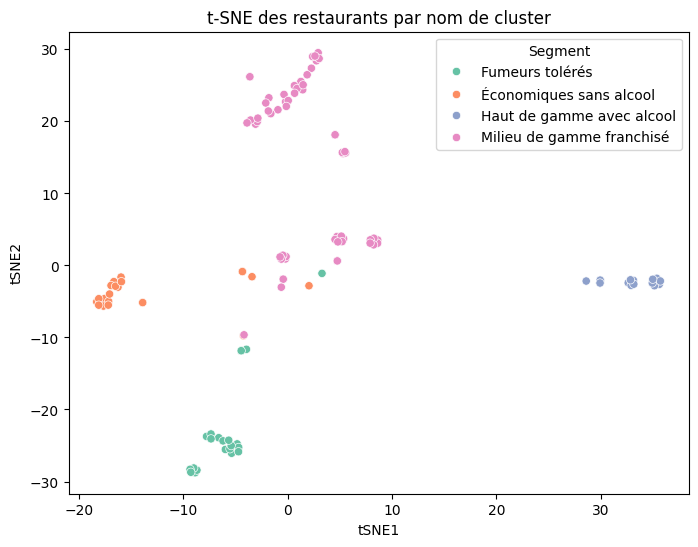

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

# Dictionnaire des noms de clusters
cluster_labels = {
    0: "Haut de gamme avec alcool",
    1: "Économiques sans alcool",
    2: "Fumeurs tolérés",
    3: "Milieu de gamme franchisé"
}

# Appliquer les noms
restaurants['Cluster_Name'] = restaurants['Cluster'].map(cluster_labels)

# t-SNE projection
tsne = TSNE(n_components=2, perplexity=10, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Visualisation
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=restaurants['Cluster_Name'], palette="Set2")
plt.title("t-SNE des restaurants par nom de cluster")
plt.xlabel("tSNE1")
plt.ylabel("tSNE2")
plt.legend(title="Segment")
plt.show()